As usual we import the libraries we are going to use : 

- pandas to deal with csv file
- numpy to manipulate arrays
- RandomForestClassifier to answer the first question
- LabelEncoder to deal with string values in the fit method of RandomForestClassifier
- linear_model to do a simple linear regression 
- matplotlib to plot 
- the two other libraries to answer the second question
- itertools for question 2
- BeautifulSoup to do find the missing position of the players

In [1]:
import pandas as pd                                     
import numpy as np                                      
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score , confusion_matrix #,silhouette_samples
import seaborn as sns
import itertools
sns.set_style("darkgrid")
%matplotlib inline
import requests
from bs4 import BeautifulSoup

# Helper functions

We first define some useful methods for the rest of the homework. 

- cross validation returns a tuple containing the average training error and the average test error of the k-fold cross validation on X and y using "estimator" to fit the model, and also the average confusion matrix.
- learning curve plots the learning curves
- describe_importances to describe the importances of the features used by the classifier 
- get_position that search the position of the player in wikipedia

In [2]:
def cross_validation(y, X, k, estimator):
 
    train_acc = []
    test_acc = []
    n = int(len(y)/k)
    average_confusion_matrix = np.zeros([5,5])

    for i in range(0,k) : 
    
        mask = np.ones(len(y), dtype=bool)
    
        if(i!=(n-1)) :
        
            mask[i*n:(i+1)*n] = False        
            y_test = y[i*n:(i+1)*n]
            X_test = X[i*n:(i+1)*n]
        
        else : 
        
            mask[i*n:] = False         
            y_test = y[i*n:] 
            X_test = X[i*n:]
    
    
        y_train = y[mask]
        X_train = X[mask]
        
        
        estimator.fit(X_train,y_train)
        train_acc.append(estimator.score(X_train,y_train))
        test_acc.append(estimator.score(X_test,y_test))
        
        average_confusion_matrix += confusion_matrix(y_test, estimator.predict(X_test) , labels = [0,1,2,3,4])
        
        
    
    return np.asarray(train_acc).mean() , np.asarray(test_acc).mean() , average_confusion_matrix/k

In [3]:
def learning_curve(X,y,estimator) : 
    
    n_samples = X.shape[0]
    train_scores = []
    test_scores = []
    abscisse = []

    for n in range(40, n_samples, 10) :
    
        abscisse.append(n)    
        train_scores.append(cross_validation(y[:n],X[:n],20,estimator)[0])
        test_scores.append(cross_validation(y[:n],X[:n],20,estimator)[1])
        
    
    plt.plot(abscisse, train_scores, 'r', abscisse, test_scores, 'b')

In [4]:
def describe_importances(X,y,estimator) : 
    
    
    estimator.fit(X,y)
    importances = estimator.feature_importances_
    std = np.std([tree.feature_importances_ for tree in estimator.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]

    print("Feature ranking:")
    print()

    for f in range(X.shape[1]):
        print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))        
        
    
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices])
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()   

In [5]:
def get_position(name):
    
    url = "https://en.wikipedia.org/wiki/"
    name_ = name.replace(' ', '_')
    final_url = url + name_
    final_url
    r = requests.get(final_url)
    soup = BeautifulSoup(r.content,"lxml")
    g_data = soup.find_all("td", {"class":"role"})
    if (len(g_data)==0) or (g_data[0].find("a") is None):
        return ''
    return g_data[0].find("a").text

## Question 1

We define a DataFrame df to store all the data

In [6]:
df = pd.read_csv('CrowdstormingDataJuly1st.csv')

First, we remove 'birthday' features that we are sure that it has nothing to do with the skin color

In [7]:
del df['birthday']

An other thing we can do to clean our data is to use one important result in the study : "Crowdsourcing data analysis: Do soccer referees give more red cards to dark skin toned players?". This result states that "If you aren't in at least 22 dyads you didn't ref a game in one of our four defining leagues", so a lot of data of our set are faulty data and we remove it.

In [8]:
df = df.set_index(['refNum'])[df['refNum'].value_counts() > 21].reset_index()

/Users/selmachraibi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


We can now split our big frame into two frames which will be the dataset (train + test) and one set that can be used for predictions for example. (In which we keep the players for which we don't have skin ratings)

We can also remove this feature after that because obviously it doesn't help in the classification

In [9]:
prediction_set = df[pd.isnull(df['photoID'])]
data_set = df[pd.notnull(df['photoID'])]

del prediction_set['photoID']
del data_set['photoID']

For this question, since the main goal is not to predict unknown values but rather to try to understand the behaviour of a random forest classifier when we change the parameters and how it affects under/overfitting, we choose to keep only the players for which the two raters agreed upon the skin color (76% of the dyades, a correct number).

Also, since RandomForestClassifier doesn't work with NaN values but also with string values, we have to find a way to tackle these two problems. 

To deal with string values, we will simply encode it using the LabelEncoder object later.

Let's see first how many missing values do we have : 

In [10]:
set_agree = data_set[data_set['rater1'] == data_set['rater2']]
del set_agree['rater2']

In [11]:
set_agree = set_agree.reset_index(drop=True)

In [12]:
mvb = set_agree.isnull().any()

for i in mvb[mvb].index : 
    print(i, ' : ',set_agree[i].isnull().sum(), ' missing values')

height  :  23  missing values
weight  :  591  missing values
position  :  6148  missing values
meanIAT  :  83  missing values
nIAT  :  83  missing values
seIAT  :  83  missing values
meanExp  :  83  missing values
nExp  :  83  missing values
seExp  :  83  missing values


We choosed to deal with the missing positions parameters since it's an attribute that is corellated with the number of yellow/red cards. For every missing position we are going to call **get_position**, a function that get the position from Wikipédia.

In [13]:
joueurs = df[df['position'].isnull()]['player']
liste = list(set(joueurs.values))
a=set(joueurs.values)
print('Number of players with missing positions : ',len(a))

Number of players with missing positions :  367


Here, we direct change the position found in the dataframe

In [14]:
joueurs = df[df['position'].isnull()]['player']
liste = list(set(joueurs.values))

for name in liste:
    true_name = name
    if name.startswith(' '):
        name = name[1:]
    indices = set_agree[set_agree['player']==true_name].index
    set_agree.iloc[indices , 7] = get_position(name)

Results of the Wikipédia scrapping:

In [15]:
b=set(set_agree[set_agree['position']=='']['player'])

print('Number of player with still missing positions = ',len(b), 
      ' Proportion of filled missing values : ', (len(a)-len(b))/len(a))

Number of player with still missing positions =  22  Proportion of filled missing values :  0.9400544959128065


The 22 missing players represent 972 rows... we delete it.

In [16]:
set_agree2 = set_agree[set_agree['position']!=''].reset_index(drop=True)

Then, we see that we have 27 different positions, so we are going to group them in only 4 categorie : Goalkeeper, Defender, Midfielier and Striker. We do it manually, sorry for the heavy code.. 

In [17]:
# Midfielder
indice1 = set_agree2[set_agree2['position'] =='Left Midfielder' ].index
set_agree2.iloc[indice1,7] = 'Midfielder'
indice2 = set_agree2[set_agree2['position'] =='Right Midfielder'].index
set_agree2.iloc[indice2,7]= 'Midfielder'
indice3 = set_agree2[set_agree2['position'] =='Central midfielder'].index
set_agree2.iloc[indice3,7]= 'Midfielder'
indice4 = set_agree2[set_agree2['position'] =='Center Back'].index
set_agree2.iloc[indice4,7]= 'Midfielder'
indice5 = set_agree2[set_agree2['position'] =='Center Forward'].index
set_agree2.iloc[indice5,7]= 'Midfielder'
indice6 = set_agree2[set_agree2['position'] =='Defensive midfielder'].index
set_agree2.iloc[indice6,7]= 'Midfielder'
indice7 = set_agree2[set_agree2['position'] =='Defensive Midfielder'].index
set_agree2.iloc[indice7,7]= 'Midfielder'
indice8 = set_agree2[set_agree2['position'] =='Attacking Midfielder'].index
set_agree2.iloc[indice8,7]= 'Midfielder'
indice9 = set_agree2[set_agree2['position'] =='Attacking midfielder'].index
set_agree2.iloc[indice9,7]= 'Midfielder'
indice10 = set_agree2[set_agree2['position'] =='Center Midfielder'].index
set_agree2.iloc[indice10,7]= 'Midfielder'
indice11 = set_agree2[set_agree2['position'] =='Centre back'].index
set_agree2.iloc[indice11,7]= 'Midfielder'
indice12 = set_agree2[set_agree2['position'] =='Centre-back'].index
set_agree2.iloc[indice12,7]= 'Midfielder'



# Striker
indice13 = set_agree2[set_agree2['position'] =='Winger' ].index
set_agree2.iloc[indice13,7] ='Striker'
indice14 = set_agree2[set_agree2['position'] =='Forward'].index
set_agree2.iloc[indice14,7]='Striker'
indice15 = set_agree2[set_agree2['position'] =='Left Winger'].index
set_agree2.iloc[indice15,7]='Striker'
indice16 = set_agree2[set_agree2['position'] =='Right Winger'].index
set_agree2.iloc[indice16,7]='Striker'


# Defender
indice17 = set_agree2[set_agree2['position'] =='Full back' ].index
set_agree2.iloc[indice17,7] = 'Defender'
indice18 = set_agree2[set_agree2['position'] =='Full-back'].index
set_agree2.iloc[indice18,7]= 'Defender'
indice19 = set_agree2[set_agree2['position'] =='Right back'].index
set_agree2.iloc[indice19,7]= 'Defender'
indice20 = set_agree2[set_agree2['position'] =='Left-back'].index
set_agree2.iloc[indice20,7]= 'Defender'
indice21 = set_agree2[set_agree2['position'] =='Left back'].index
set_agree2.iloc[indice21,7]= 'Defender'
indice22 = set_agree2[set_agree2['position'] =='Right Fullback'].index
set_agree2.iloc[indice22,7]= 'Defender'
indice23 = set_agree2[set_agree2['position'] =='Left Fullback'].index
set_agree2.iloc[indice23,7]= 'Defender'

We now have our 4 positions !

In [18]:
set_agree2['position'].value_counts()

Midfielder    57244
Defender      12995
Striker        8383
Goalkeeper     7850
Name: position, dtype: int64

We suspect that the 83 missing values in the 6 last columns correspond to the same rows. We will simply delete it 

In [19]:
set_agree2 = set_agree2[set_agree2['nIAT'].notnull()]

We have 23 missing values left for the height, and 591 missing values left for the weight. 
The missing values for the height correspond to only 3 players, we delete it.

In [20]:
set_agree2 = set_agree2[set_agree2['height'].notnull()]


To fill the missing values for the weight, we will do a simple linear regression using sklearn : 

$$weight = \beta_{0} + \beta_{1}*height$$ 

Because we can consider that soccer players have more or less the same weight for a given height (can't be very fat or very thin)

In [21]:
data_points = df[['playerShort', 'height' , 'weight']].drop_duplicates()[['height','weight']]
data_points.dropna(inplace=True)
data_points.head()

,height,weight
0,182.0,71.0
1,187.0,80.0
2,180.0,68.0
3,193.0,80.0
4,180.0,70.0


In [22]:
x = np.asarray(data_points['height'])
y = np.asarray(data_points['weight'])

rl = linear_model.LinearRegression()
rl.fit(x.reshape(x.shape[0],1) , y.reshape(y.shape[0],1))

for index in set_agree2[set_agree2['weight'].isnull()].index : 
    
    set_agree2.set_value(index=index, col='weight' , value = int(rl.predict(set_agree2.loc[index].height)))

Now we are done with missing values. We have to encode the categorical features : (to encode the feature "rating", we prefer to use the map function of pandas to keep the values ordered) 

In [23]:
le_club = LabelEncoder()
la_position = LabelEncoder()
le_leaguecountry = LabelEncoder()
le_alpha = LabelEncoder()
map_skin = {0 : 0 , 0.25 : 1 , 0.5 : 2 , 0.75 : 3 , 1 : 4}

le_club.fit(set_agree2['club'])
la_position.fit(set_agree2['position'])
le_leaguecountry.fit(set_agree2['leagueCountry'])
le_alpha.fit(set_agree2['Alpha_3'])

set_agree2['club'] = le_club.transform(set_agree2['club'])
set_agree2['position'] = la_position.transform(set_agree2['position'])
set_agree2['leagueCountry'] = le_leaguecountry.transform(set_agree2['leagueCountry'])
set_agree2['Alpha_3'] = le_alpha.transform(set_agree2['Alpha_3'])
set_agree2['rater1'] = set_agree2['rater1'].map(arg=map_skin)

Now, we create an other dataframe that contains information about players (We create it from the dataframe set_agree)

In [24]:
soccer_player_information = pd.DataFrame()
set_agree2.set_index(['playerShort'],inplace=True)

for soccer_player in set(set_agree2.index) : 
    
    temp_frame = set_agree2.loc[soccer_player]   
    
   
    seExp = np.std(a=temp_frame['meanExp'])
    seIAT = np.std(a=temp_frame['meanIAT'])    
    
    
    player_information = {'playerShort' : soccer_player,
                          'position' : temp_frame['position'].mean(),
                          'club' : temp_frame['club'].mean(),    #Since it's always the same club, same argument for the rest
                          'leagueCountry' : temp_frame['leagueCountry'].mean(), 
                          'height' : temp_frame['height'].mean(),
                          'weight' : temp_frame['weight'].mean(),
                          'totalGames' : temp_frame['games'].sum(),
                          'totalVictories' : temp_frame['victories'].sum() ,
                          'totalTies' : temp_frame['ties'].sum() ,
                          'totalDefeats' : temp_frame['defeats'].sum() ,
                          'totalGoals' : temp_frame['goals'].sum() ,
                          'totalYellowCards' :temp_frame['yellowCards'].sum() ,
                          'totalYellowReds' :temp_frame['yellowReds'].sum() ,  
                          'totalRedCards' :temp_frame['redCards'].sum(),
                          'rating' : temp_frame['rater1'].mean(),
                          'meanIAT' : temp_frame['meanIAT'].mean(),
                          'meanExp' : temp_frame['meanExp'].mean(),
                          'seIAT' :  seIAT,
                          'seExp' : seExp}
    
    soccer_player_information = soccer_player_information.append(pd.Series(player_information), ignore_index=True)

# Machine Learning Methods

We create classifiers with different parameters. Classifier1 is the classifier by default, which will probably be a good classifier. The two other ones will probably be bad classifiers and have a large bias because of the restrictions we imposed : 

In [25]:
classifier1 = RandomForestClassifier() #Default classifier
classifier2 = RandomForestClassifier(max_leaf_nodes=2)
classifier3 = RandomForestClassifier(max_depth=4)

We create the label vector and delete the feature 'playerShort' which is useless

In [26]:
y = soccer_player_information['rating']
del soccer_player_information['rating']
del soccer_player_information['playerShort']

** Results of the classifiers : **

In [27]:
for i , classifier in enumerate([classifier1 , classifier2 , classifier3]) : 
    
    av_train_acc , av_test_acc , conf_mat = cross_validation(y, soccer_player_information, 5, classifier)    
    
    print('Classifier',i+1, ' : ')
    print('Average train accuracy : ', av_train_acc)
    print('Average test accuracy : ', av_test_acc)
    print('Confusion matrix :\n ', conf_mat)
    print()

Classifier 1  : 
Average train accuracy :  0.981144067797
Average test accuracy :  0.419491525424
Confusion matrix :
  [[ 49.2  31.2   1.2   0.8   1. ]
 [ 41.4  43.4   2.2   2.4   1.6]
 [  9.   11.    0.8   1.4   0.6]
 [  7.2   7.6   0.4   2.8   2.4]
 [  4.8   6.4   0.6   3.8   2.8]]

Classifier 2  : 
Average train accuracy :  0.420974576271
Average test accuracy :  0.388983050847
Confusion matrix :
  [[ 23.   60.4   0.    0.    0. ]
 [ 22.2  68.8   0.    0.    0. ]
 [  6.2  16.6   0.    0.    0. ]
 [  6.   14.4   0.    0.    0. ]
 [  5.4  13.    0.    0.    0. ]]

Classifier 3  : 
Average train accuracy :  0.531355932203
Average test accuracy :  0.433898305085
Confusion matrix :
  [[ 43.6  39.    0.    0.2   0.6]
 [ 34.8  54.2   0.    0.    2. ]
 [ 10.   11.6   0.    0.4   0.8]
 [  8.2   8.8   0.    0.8   2.6]
 [  7.    6.6   0.    1.    3.8]]



** Analysis of the results : **

- ** Classifier 1 : **

We can clearly see that we are facing overfitting with this classifier. (More than 98% accuracy in the train set and a little bit less than 40% accuracy in the test set, which is not a very bad score with 5 labels). By looking at the confusion matrix, we see that for the light skin people (0.0 and 0.25) we do a good classification. Indeed most of them are well classified and the misclassified ones are in a adjacent class. On the other hand, we see also that we are doing a bad classification for dark skin people (> 0.25) : we will explain why by looking at the results of the two other classifiers.

- ** Classifier 2 and 3 : **

Clearly, if we don't let the tree grow or we strongly restrict the number of leaves as we did, we will get very bad results in the classification. However, even if we have very bad results on the train set (predictable) the results of the test set aren't bad, more than that : they can be better than a good classifier. Why is that ? To explain this result let's first look at the distribution of the skin color in our data set : 

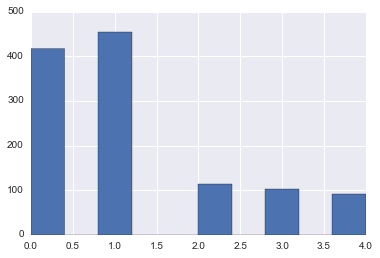

In [28]:
y.hist()

We see that this distribution is very skewed. Indeed, the light skin people (0.0 and 0.25) represent about 75% of our dataset. That's why the classifier tends to classify a lot the players in these classes and that explain the above results.

Now let's take a look at the features importances of the classifiers : 

**Classifier 1 : **

Feature ranking:

1. seIAT (0.091183)
2. meanIAT (0.078434)
3. seExp (0.075776)
4. totalDefeats (0.072971)
5. club (0.072820)
6. meanExp (0.071326)
7. totalYellowCards (0.068564)
8. weight (0.063990)
9. totalGoals (0.062407)
10. totalGames (0.062315)
11. height (0.061289)
12. totalVictories (0.059732)
13. totalTies (0.057814)
14. totalYellowReds (0.026760)
15. leagueCountry (0.026679)
16. totalRedCards (0.026345)
17. position (0.021595)


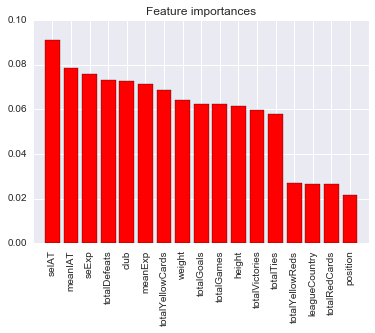

In [29]:
describe_importances(soccer_player_information,y,classifier1)

** Classifier 2 ** 

Feature ranking:

1. seExp (0.300000)
2. totalYellowCards (0.200000)
3. height (0.100000)
4. totalTies (0.100000)
5. leagueCountry (0.100000)
6. meanExp (0.100000)
7. seIAT (0.100000)
8. weight (0.000000)
9. meanIAT (0.000000)
10. position (0.000000)
11. totalDefeats (0.000000)
12. totalYellowReds (0.000000)
13. totalGames (0.000000)
14. totalGoals (0.000000)
15. totalRedCards (0.000000)
16. totalVictories (0.000000)
17. club (0.000000)


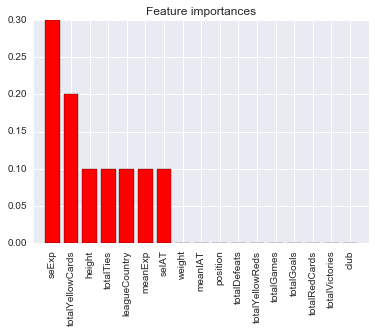

In [30]:
describe_importances(soccer_player_information,y,classifier2)

** Classifier 3 **

Feature ranking:

1. seExp (0.156625)
2. meanIAT (0.137752)
3. club (0.117678)
4. seIAT (0.105273)
5. totalGames (0.071542)
6. totalVictories (0.058689)
7. totalYellowCards (0.055845)
8. leagueCountry (0.055072)
9. weight (0.052532)
10. meanExp (0.049909)
11. totalTies (0.033624)
12. position (0.029860)
13. totalDefeats (0.026725)
14. height (0.026307)
15. totalYellowReds (0.017691)
16. totalGoals (0.004876)
17. totalRedCards (0.000000)


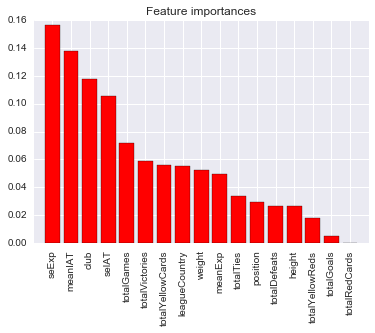

In [31]:
describe_importances(soccer_player_information,y,classifier3)

An interesting thing is that even if these 2 classifiers achieve the same accuracy, the ranking of the features is not the same and especially their importances. 

# An other feature selection

In this part, we will make other assumptions initial features and will see if there are differences on the accuracy and in in the results of **feature importances**.

In [32]:
player_info2 = soccer_player_information.copy()

As we assume that there might be a correlation between **number of yellow-red card**/**skin color**, we thought that the total number of yellow-red card have no sense, since some players have played 2 **Games** and others 100 !
Therefore we modify the three **yellow-red Cards** parameter averaging them to have a **"Cards-per-match"** parameter.

In [33]:
player_info2['totalRedCards'] = player_info2['totalRedCards']/player_info2['totalGames']
player_info2['totalYellowCards'] = player_info2['totalYellowCards']/player_info2['totalGames']
player_info2['totalYellowReds'] = player_info2['totalYellowReds']/player_info2['totalGames']

In [34]:
new_cols = list(player_info2.columns)
new_cols[10] = 'RedCard-Per-Match'
new_cols[13] = 'YellowCard-Per-Match'
new_cols[14] = 'YellowReds-Per-Match'
player_info2.columns = new_cols

In [35]:
player_info2.head()

,club,height,leagueCountry,meanExp,meanIAT,position,seExp,seIAT,totalDefeats,totalGames,RedCard-Per-Match,totalRedCards,totalTies,YellowCard-Per-Match,YellowReds-Per-Match,totalYellowReds,weight
0,49.0,180.0,1.0,0.396648,0.342820,0.0,0.164520,0.021884,41.0,137.0,7.0,0.021898,35.0,61.0,0.211679,0.000000,74.0
1,6.0,172.0,0.0,0.571166,0.355434,2.0,0.273332,0.033884,72.0,311.0,72.0,0.006431,77.0,162.0,0.093248,0.000000,69.0
2,10.0,180.0,3.0,0.513491,0.358734,0.0,0.135626,0.023869,113.0,364.0,18.0,0.002747,89.0,162.0,0.167582,0.002747,72.0
3,65.0,187.0,3.0,0.610543,0.370791,2.0,0.107152,0.008339,60.0,200.0,52.0,0.000000,62.0,78.0,0.040000,0.000000,77.0
4,27.0,190.0,2.0,0.356839,0.338602,2.0,0.124139,0.011711,77.0,179.0,12.0,0.005587,48.0,54.0,0.212291,0.005587,85.0


We will assume that there is no correlation between **weight**/**skin color**. Same asumption for the **number of victory**, **ties**, **defeat**, **games**, the **club** and the **number of goal** . So we remove all these features.

In [36]:
player_info2 = player_info2.drop(['weight','club','totalDefeats','totalTies', 'totalGames'],axis=1,inplace=False)

Using a GridSearch CV that we don't show here to not complicated the Notebook, we find that the best classifier is the following.

In [37]:
best_classifier = RandomForestClassifier(max_depth = 6, max_features = 8)

av_train_acc , av_test_acc, conf_mat = cross_validation(y, player_info2, 20, best_classifier)    
     
print('Best_Classifier')
print('Average train accuracy : ', av_train_acc)
print('Average test accuracy : ', av_test_acc)
print('Confusion matrix :\n ', conf_mat)

Best_Classifier
Average train accuracy :  0.614629794826
Average test accuracy :  0.420338983051
Confusion matrix :
  [[ 10.9    9.65   0.05   0.1    0.15]
 [  9.35  12.45   0.15   0.4    0.4 ]
 [  2.15   3.15   0.05   0.3    0.05]
 [  1.7    2.25   0.     0.35   0.8 ]
 [  1.55   1.5    0.15   0.35   1.05]]


Finally, we reach the same accuracy with 6 features removed, it means that former features where useless. Despite this, this model is still failing with predicting players with skin color >= 0,50. This is certainly due to :
- the lack of player of labels >=0.5.
- Bad feature selection ?

Let's see the feature importance !

### Feature Importance

Feature ranking:

1. seIAT (0.160394)
2. meanIAT (0.113322)
3. meanExp (0.108972)
4. YellowCard-Per-Match (0.105602)
5. seExp (0.103343)
6. YellowReds-Per-Match (0.097127)
7. height (0.081868)
8. leagueCountry (0.067380)
9. totalRedCards (0.063372)
10. totalYellowReds (0.050100)
11. RedCard-Per-Match (0.044503)
12. position (0.004017)


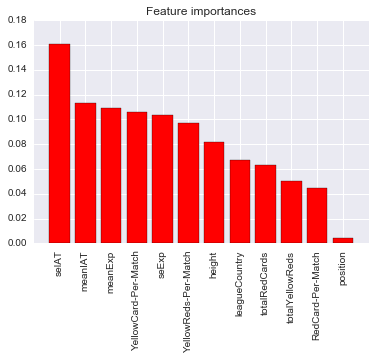

In [38]:
describe_importances(player_info2,y,best_classifier)

# Bonus Question : Learning Curves 

Let's plot the learning curves of the classifiers. We have the train error in red and the test error in blue. 

** Classifier 1 : ** 

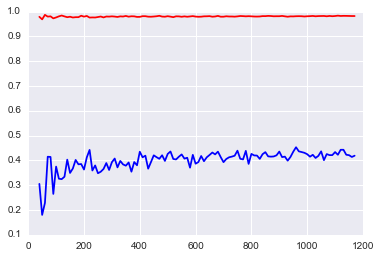

In [39]:
learning_curve(soccer_player_information,y,classifier1)

High variance phenomenon. We can see that with this optimal classifier, the train accuracy is (not surprisingly) always close to 100%. However, the test accuracy do not go above 50% : one reason can be that the features aren't appropriate for the problem, and don't explain well the skin color. Maybe if we had a uniform distribution of the skin colors, we would see the blue line around 20%. 

** Classifier 2 : ** 

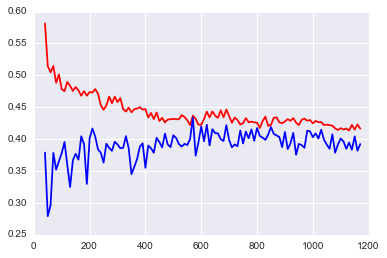

In [40]:
learning_curve(soccer_player_information,y,classifier2)

High Bias phenomenon. As we can see, setting the "maximum number of leaves" parameter to 2 lead to a large bias : we start at an already low train accuracy and then it decreases and meet the test accuracy curve around 40%. Again we explain this result by thinking at the distribution of the skin colors.

** Classifier 3 : ** 

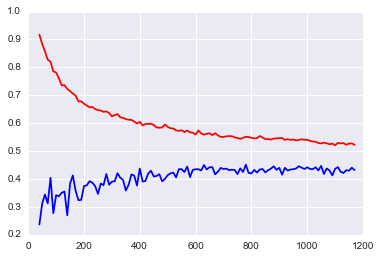

In [41]:
learning_curve(soccer_player_information,y,classifier3)

If we don't let the tree grow, the more samples we have the worse is our train error. Again, it seems that the two curves converge to a certain accuracy explained by the distribution of the skin color.

In [42]:
soccer_player_information.columns

Index(['club', 'height', 'leagueCountry', 'meanExp', 'meanIAT', 'position',
       'seExp', 'seIAT', 'totalDefeats', 'totalGames', 'totalGoals',
       'totalRedCards', 'totalTies', 'totalVictories', 'totalYellowCards',
       'totalYellowReds', 'weight'],
      dtype='object')

## Question 2 

Again, we use the set of players where the two raters agreed upon the skin color. This time we keep only the referee information (that is, the number of yellow/red cards and the statistical informations about the referees: IAT and Exp) we also add the games satistic informations for the player (number of games, victories, dedeats and ties) and we group it by player. 

In [43]:
referee_information = soccer_player_information[['totalRedCards','totalYellowCards','totalYellowReds','meanIAT',
                                                 'meanExp','seExp','seIAT', 'totalGames', 'totalGoals','totalDefeats',
                                                 'totalTies','totalVictories']]

referee_information.head()

,totalRedCards,totalYellowCards,totalYellowReds,meanIAT,meanExp,seExp,seIAT,totalGames,totalGoals,totalDefeats,totalTies,totalVictories
0,3.0,29.0,0.0,0.342820,0.396648,0.164520,0.021884,137.0,7.0,41.0,35.0,61.0
1,2.0,29.0,0.0,0.355434,0.571166,0.273332,0.033884,311.0,72.0,72.0,77.0,162.0
2,1.0,61.0,1.0,0.358734,0.513491,0.135626,0.023869,364.0,18.0,113.0,89.0,162.0
3,0.0,8.0,0.0,0.370791,0.610543,0.107152,0.008339,200.0,52.0,60.0,62.0,78.0
4,1.0,38.0,1.0,0.338602,0.356839,0.124139,0.011711,179.0,12.0,77.0,48.0,54.0


Before doing the clustering, we need do to choose the most appropriate algorithm.
Our goal is to obtain 2 clusters representing the skin color of the players, one for white skin and one for black skin. Following the theory, we opted for K-means that allows us to choose the number of clusters.

First, we compute the K-means with all the features selected previously.

In [44]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(referee_information)
score = silhouette_score(referee_information, kmeans.labels_)
score

0.54362802668248522

The score obtained is not very high, thus we will try to find a subset of these features with a higher silhouette score.
To do this, we remove iteratively the features.
Since we have only 13 features, we will compute the combinations for 12 features and we will perform K-means algorithm with all possible combinations and compute the silhouette score for each configuration and keep the best. At each iteration, we remove the feature that gives the worst silhouette score and do the same thing by decreasing the size of the number of features until we have a subset size of 1.
We then store the results in a Pandas series scores_config.

In [45]:
features = ['totalRedCards','totalYellowCards','totalYellowReds','meanIAT',
            'meanExp','seExp','seIAT', 'totalGames', 'totalGoals','totalDefeats','totalTies','totalVictories']

L = len(features)
best_config_per_size = pd.DataFrame(columns=['size','best_config','score'])

while L > 0 :    
    

    best_config = []
    best_score = 0
    
    for config in itertools.combinations(features, L):
    
        config = list(config)        
        kmeans = KMeans(n_clusters=2, random_state=0).fit(referee_information[config])
        score = silhouette_score(referee_information[config], kmeans.labels_)
        
        if(score > best_score) : 
            
            best_config = config
            best_score = score
        
    
    temp = {'size' : L , 'best_config' : best_config , 'score' : best_score}    
    best_config_per_size = best_config_per_size.append(temp , ignore_index=True) 
    features = best_config
    L = L-1
        

In [46]:
best_config_per_size

,size,best_config,score
0,12.0,"[totalRedCards, totalYellowCards, totalYellowR...",0.543628
1,11.0,"[totalRedCards, totalYellowCards, totalYellowR...",0.558838
2,10.0,"[totalRedCards, totalYellowReds, meanIAT, mean...",0.569918
3,9.0,"[totalRedCards, totalYellowReds, meanIAT, mean...",0.580771
4,8.0,"[totalRedCards, totalYellowReds, meanIAT, mean...",0.588249
5,7.0,"[totalRedCards, totalYellowReds, meanIAT, mean...",0.594758
6,6.0,"[totalRedCards, meanIAT, meanExp, seExp, seIAT...",0.594996
7,5.0,"[totalRedCards, meanIAT, meanExp, seExp, seIAT]",0.700274
8,4.0,"[totalRedCards, meanIAT, seExp, seIAT]",0.711583
9,3.0,"[totalRedCards, meanIAT, seIAT]",0.727904


We can notice that the top-11 silhouette scores are closed to each others but it seems that the best configuration is when we keep only the features 'RedCards' and 'meanIAT'. Let's take a look at the results : 

In [47]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(referee_information[['totalRedCards','meanIAT']])

referee_information['cluster'] = kmeans.labels_
referee_information['color_skin'] = y
referee_information.head()

/Users/selmachraibi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/selmachraibi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,totalRedCards,totalYellowCards,totalYellowReds,meanIAT,meanExp,seExp,seIAT,totalGames,totalGoals,totalDefeats,totalTies,totalVictories,cluster,color_skin
0,3.0,29.0,0.0,0.342820,0.396648,0.164520,0.021884,137.0,7.0,41.0,35.0,61.0,1,2.0
1,2.0,29.0,0.0,0.355434,0.571166,0.273332,0.033884,311.0,72.0,72.0,77.0,162.0,1,0.0
2,1.0,61.0,1.0,0.358734,0.513491,0.135626,0.023869,364.0,18.0,113.0,89.0,162.0,0,0.0
3,0.0,8.0,0.0,0.370791,0.610543,0.107152,0.008339,200.0,52.0,60.0,62.0,78.0,0,0.0
4,1.0,38.0,1.0,0.338602,0.356839,0.124139,0.011711,179.0,12.0,77.0,48.0,54.0,0,0.0


When looking at the result, we understand that the cluster 1 correspond to the players who have a lot of red cards and the cluster 0 to the players who haven't. Let's see the distribution of skin colors in the two clusters : 

** Number of players in cluster 0 : **

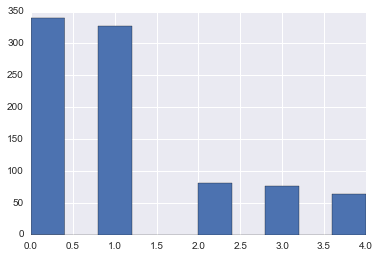

In [48]:
referee_information[referee_information['cluster'] == 0]['color_skin'].hist()

** Number of players in cluster 1 : **

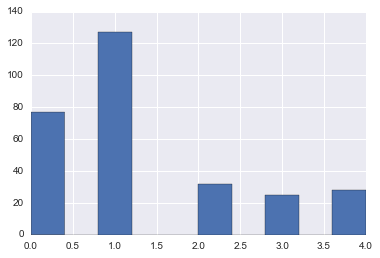

In [49]:
referee_information[referee_information['cluster'] == 1]['color_skin'].hist()

From the plots, we can clearly say that skin color does not impact clustering.
The proportions seem to be the same independent of skin color. We could conclude that there is no racism here, and that the referees are fair. 